In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms , datasets
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

In [3]:
# Define transformations (resize to 64x64, normalize to [-1, 1])
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
dataset_folder = '/content/drive/MyDrive/Colab Notebooks/datasets/Abstract_gallery'
# Load dataset
dataset = datasets.ImageFolder(root=dataset_folder, transform=transform)

# Configure data loader with batch size and number of workers
data_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

In [7]:
# Define Generator
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()
        self.img_shape = img_shape
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, img_shape[0] * img_shape[1] * img_shape[2]),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)
        return img

In [8]:
# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_shape[0] * img_shape[1] * img_shape[2], 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

In [9]:
# Define Loss Function
adversarial_loss = nn.BCELoss()

# Initialize Generator and Discriminator
latent_dim = 100
img_shape = (3, 64, 64)  # Change the shape according to your dataset
generator = Generator(latent_dim, img_shape)
discriminator = Discriminator(img_shape)

In [11]:
# GPU Setting
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)
print(device)

cuda


In [12]:
# Configure Data Loader
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = ImageFolder(root=dataset_folder, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


In [13]:
# Define Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [14]:
# Training Loop
num_epochs = 50
g_losses = []
d_losses = []
for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = torch.ones(imgs.size(0), 1, device=device)
        fake = torch.zeros(imgs.size(0), 1, device=device)

        # Configure input
        real_imgs = imgs.to(device)

        # Train Generator
        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = torch.randn(imgs.size(0), latent_dim, device=device)

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

        print(
            f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]"
        )

[Epoch 0/50] [Batch 0/44] [D loss: 0.695440411567688] [G loss: 0.6777721047401428]
[Epoch 0/50] [Batch 1/44] [D loss: 0.5283401608467102] [G loss: 0.8126662969589233]
[Epoch 0/50] [Batch 2/44] [D loss: 0.3674865961074829] [G loss: 1.0141922235488892]
[Epoch 0/50] [Batch 3/44] [D loss: 0.2684185206890106] [G loss: 1.2626416683197021]
[Epoch 0/50] [Batch 4/44] [D loss: 0.1918163001537323] [G loss: 1.4910918474197388]
[Epoch 0/50] [Batch 5/44] [D loss: 0.16492345929145813] [G loss: 1.6113498210906982]
[Epoch 0/50] [Batch 6/44] [D loss: 0.19530177116394043] [G loss: 1.5799413919448853]
[Epoch 0/50] [Batch 7/44] [D loss: 0.174330472946167] [G loss: 1.4401342868804932]
[Epoch 0/50] [Batch 8/44] [D loss: 0.21439076960086823] [G loss: 1.2787456512451172]
[Epoch 0/50] [Batch 9/44] [D loss: 0.24109160900115967] [G loss: 1.1764163970947266]
[Epoch 0/50] [Batch 10/44] [D loss: 0.23468071222305298] [G loss: 1.1255755424499512]
[Epoch 0/50] [Batch 11/44] [D loss: 0.25696083903312683] [G loss: 1.0902

KeyboardInterrupt: 

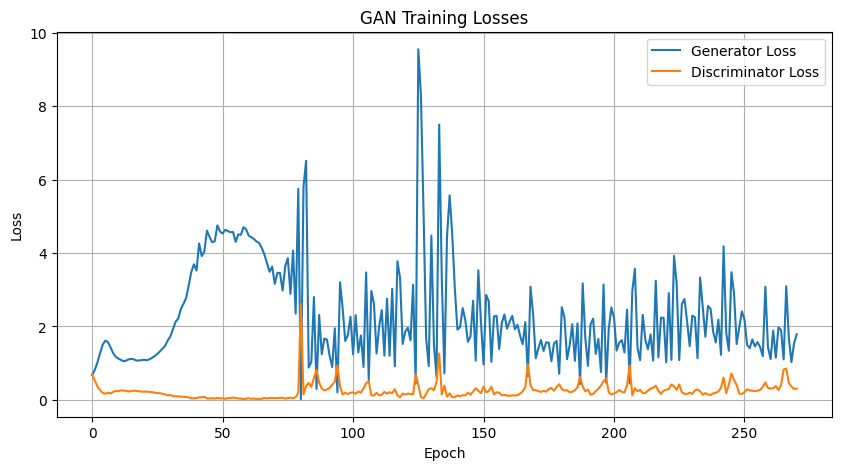

In [15]:
# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label='Generator Loss')
plt.plot(d_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN Training Losses')
plt.legend()
plt.grid(True)
plt.show()

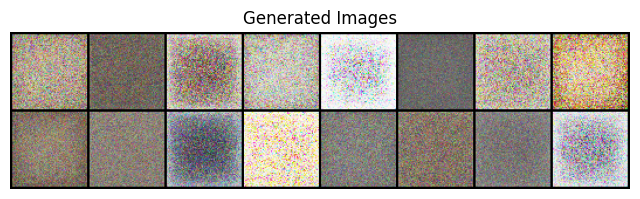

In [16]:
import torchvision.utils as vutils
import numpy as np

# Generate new data
num_samples = 16
z = torch.randn(num_samples, latent_dim, device=device)
with torch.no_grad():
    fake_images = generator(z).detach().cpu()

# Plot the generated images
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True), (1, 2, 0)))
plt.show()